In [2]:
import numpy as np
import pandas as pd
import datetime
import dateutil
from scipy.optimize import root_scalar
from math import log, exp
from scipy.stats import norm
from random import random
import matplotlib.pyplot as plt

In [3]:
def precios_bono(fecha_valuacion, valor_nominal,tasa_cupon,
                 fecha_vencimiento, YTM,tasa_interbancaria,R):
    #Las fechas de valuación y vencimiento se deben ingresar bajo el siguiente formato: "dd/mm/aaaa"
    #Las tasas de cupón, YTM, interbancaria y de recuperación (R) deben ingresarse bajo el siguiente formato "x%"
    #El valor nominal debe ingresarse de la siguiente fomra: 100.0000
    
    
    t = datetime.datetime.strptime(fecha_valuacion,"%d/%m/%Y")
    T = datetime.datetime.strptime(fecha_vencimiento,"%d/%m/%Y")
    T2 = datetime.datetime.strptime(fecha_vencimiento,"%d/%m/%Y") - dateutil.relativedelta.relativedelta(months=6)
    fin_cupon = [T]
    VN = valor_nominal
    c = float(tasa_cupon.replace("%",""))/200
    i = float(YTM.replace("%",""))/200
    i2 = float(tasa_interbancaria.replace("%",""))/200
    R = float(R.replace("%",""))/100
    
    cc = 0 #CONTADOR DE CUPONES
    while T2 > t:
        cc = cc + 1
        fin_cupon.append(T2)
        T2 = T2 - dateutil.relativedelta.relativedelta(months=6)
    
    fin_cupon = sorted(fin_cupon)
    inicio_cupon = [] 
    dias_cupon = []
    
    for j in fin_cupon:
        inicio_cupon.append(j-dateutil.relativedelta.relativedelta(months=6))
        dias_cupon.append(360 * (j.year - t.year) + 30 * (j.month - t.month) + min(30, j.day) - min(30, t.day))
        
    Num_cupon = [i for i in range(1,len(fin_cupon)+1)]
    tabla = pd.DataFrame(list(zip(Num_cupon,inicio_cupon, fin_cupon,dias_cupon)), 
               columns =['No cupón','Inicio_cupón', 'Fin_cupón','Días_cupón'])
    
    tabla["Cupón + Nocional"] = c*VN
    tabla["Cupón + Nocional"].iloc[-1] = (tabla["Cupón + Nocional"].iloc[-1]+VN)
    tabla["F.Descuento"] = 1/((1+i))**(tabla["Días_cupón"]/180)
    tabla["F.Descuento Interbancario"] = 1/((1+i2))**(tabla["Días_cupón"]/180)
    
    precio_sucio = tabla["Cupón + Nocional"]@tabla["F.Descuento"]
    intereses_devengados = tabla["Cupón + Nocional"].iloc[0]*((180-tabla["Días_cupón"].iloc[0])/180)
    precio_limpio = precio_sucio - intereses_devengados
    
    a = tabla["F.Descuento Interbancario"].values
    b = tabla["Cupón + Nocional"].values
    
    def h_optima(h):
        incumplimientos = []
        for k in range(0,tabla.shape[0]+1):
            incumplimientos.append((1-h)**k)
        
        d = incumplimientos[0:-1]
        e = incumplimientos[1::]
        return (precio_sucio-(sum(b*a*e)+sum(a*d)*R*h*VN))*10000
    
    res0 = root_scalar(h_optima,bracket=[0, 1], method='brentq')
    #res = .0464728802144729
    res = res0.root #h_optima : probabilidad de incumplimiento ópmita
    
    incumplimientos = []
    
    for k in range(0,tabla.shape[0]+1):
        incumplimientos.append((1-res)**k)
    
    d = incumplimientos[0:-1]
    e = incumplimientos[1::]
    risk_price = (sum(b*a*e)+sum(a*d)*R*res*VN)
    probabilidad_incumplimiento = f"{res*100}%"
    
    return {"Tabla":tabla,"Precio sucio": precio_sucio,"Precio limpio":precio_limpio,"Risk price":risk_price, "h_optima": probabilidad_incumplimiento}



In [13]:
def CVA(precio_spot, plazo, pts_fwd, Tasa_USD,volatilidad,paso,nocional,prob_incump_h,tasa_tiie):
    
    tasa_USD = float(Tasa_USD.replace("%",""))/100
    vol = float(volatilidad.replace("%",""))/100
    h = float(prob_incump_h.replace("%",""))/100
    tiie = float(tasa_tiie.replace("%",""))/100
    precio_fwd =precio_spot + (pts_fwd/10000)
    tasa_implicita_MXN = ((precio_fwd/precio_spot)*(1+tasa_USD*plazo/360)-1)*(360/plazo)
    q = (360/plazo)*log(1+tasa_USD*plazo/360)
    r = (360/plazo)*log(1+tasa_implicita_MXN*plazo/360)
    
    simulaciones = np.zeros(shape=(1000,plazo+1))  #tray/tiempo
    for j in range(simulaciones.shape[0]):
        for i in range(simulaciones.shape[1]):
            if i == 0:
                simulaciones[j,i] = precio_spot
            else:
                simulaciones[j,i] = simulaciones[j,i-1]*exp((r-q-0.5*vol*vol)*(paso/360)+vol*(paso/360)**0.5*norm.ppf(random()))
    
    mtm = np.zeros(shape =(1000,plazo+1))
    for j in range(mtm.shape[0]):
        for i in range(mtm.shape[1]):
            mtm[j,i] = nocional*(simulaciones[j,i]*exp((r-q)*(plazo - i)/360)-precio_fwd)*exp(-r*(plazo-i)/360)
    
    def avg(x):
        return x[x > 0].mean()
    
    EPE = np.apply_along_axis(avg, 0, np.array(mtm[:,1:]))
    EPE = EPE.reshape(plazo,1)
    PFE = np.percentile(mtm[:,1:], 95, axis=0)
    PFE = PFE.reshape(plazo,1)
    
    df_tiie = np.zeros(shape=(plazo,1))
    prob_cond = np.zeros(shape=(plazo,1))
    
    for i in range(plazo):
        df_tiie[i,0]= 1/(1+tiie*91/360)**((i+1)/91)
        prob_cond[i,0] =1-(1-h)**((i+1)/180)-(1-(1-h)**((i)/180))
    
    CVA_EPE = 0
    CVA_PFE = 0
    for i in range(plazo):
        CVA_EPE = CVA_EPE + float(EPE[i]*df_tiie[i]*prob_cond[i])
        CVA_PFE = CVA_PFE + float(PFE[i]*df_tiie[i]*prob_cond[i])
    
    MTM = pd.DataFrame(mtm[:,1:], columns = [x for x in range(1,mtm[:,1:].shape[1]+1)])
    
    
    def strike_EPE(s):
        return nocional*(s-precio_fwd)*exp(-r*plazo/360) - CVA_EPE
    
    def strike_PFE(s):
        return nocional*(s-precio_fwd)*exp(-r*plazo/360) - CVA_PFE
    
    nuevo_strike_EPE = root_scalar(strike_EPE,bracket=[0, precio_spot*2], method='brentq').root
    nuevo_strike_PFE = root_scalar(strike_PFE,bracket=[0, precio_spot*2], method='brentq').root
    
    
    
    
    return CVA_EPE, CVA_PFE, MTM.T,mtm,nuevo_strike_EPE,nuevo_strike_PFE

In [6]:
b = precios_bono("11/03/2020", 100,"6.5%" ,"13/03/2027", "8.55079","0.67%","25%")

In [20]:
b["Tabla"]

,No cupón,Inicio_cupón,Fin_cupón,Días_cupón,Cupón + Nocional,F.Descuento,F.Descuento Interbancario
0,1,2019-09-13,2020-03-13,2,3.25,0.999535,0.999963
1,2,2020-03-13,2020-09-13,182,3.25,0.958553,0.996624
2,3,2020-09-13,2021-03-13,362,3.25,0.919251,0.993297
3,4,2021-03-13,2021-09-13,542,3.25,0.881561,0.989980
4,5,2021-09-13,2022-03-13,722,3.25,0.845416,0.986675
5,6,2022-03-13,2022-09-13,902,3.25,0.810753,0.983380
6,7,2022-09-13,2023-03-13,1082,3.25,0.777512,0.980097
7,8,2023-03-13,2023-09-13,1262,3.25,0.745633,0.976825
8,9,2023-09-13,2024-03-13,1442,3.25,0.715061,0.973563
9,10,2024-03-13,2024-09-13,1622,3.25,0.685743,0.970313


In [7]:
b["Precio sucio"]

92.56985113848998

In [8]:
b["Risk price"]

92.5698511384897

In [9]:
b["h_optima"]

'4.647288024541443%'

In [14]:
CVA_epe, CVA_pfe, MTM, mtm,strike_EPE, strike_PFE = CVA(21.77,90,4118,".78412%","20%",1,10000000,b["h_optima"],"7.13%")

In [15]:
CVA_epe

282155.4990231051

In [16]:
CVA_pfe

593297.2531274701

In [17]:
strike_EPE

22.210605630734356

In [18]:
strike_PFE

22.24237050686046

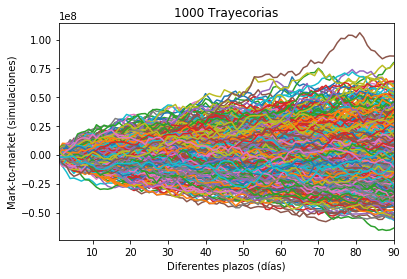

In [19]:
MTM.plot(legend=False)
plt.xlabel("Diferentes plazos (días)")
plt.ylabel("Mark-to-market (simulaciones)")
plt.title("1000 Trayecorias");